<a href="https://colab.research.google.com/github/ReAlex1902/MRI_tumor_detection/blob/main/MRI_tumor_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alexdraxler","key":"c40fb28a10fe06e8e9575f938ee96f68"}'}

In [3]:
#before importing the dataset we want to use this code
# The Kaggle API client expects this file to be in ~/.kaggle,
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

 99% 705M/714M [00:27<00:00, 36.7MB/s]
100% 714M/714M [00:27<00:00, 26.8MB/s]


In [5]:
# Downloading dataset:
from zipfile import ZipFile

# # The below code is ran in google colab
# os.environ["KAGGLE_USERNAME"] = "KAGGLE_USERNAME"  # username from the json file
# os.environ["KAGGLE_KEY"] = "KAGGLE_KEY"  # key from the json file
# !kaggle datasets download -d praveengovi/coronahack-chest-xraydataset  # api copied from kaggle

# Create a ZipFile Object and load chest-xray-pneumonia.zip in it
PATH = '/content/lgg-mri-segmentation.zip'
with ZipFile(PATH, "r") as zipObj:
    # Extract all the contents of zip file in current directory
    zipObj.extractall()

#Creating DataFrame

In [6]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import ImageGrid

In [7]:
PATH = '/content/lgg-mri-segmentation/kaggle_3m/'

dirnames = []
paths = []
i = 0
for sub_dir in os.listdir(PATH):
    folder = os.path.join(PATH, sub_dir)
    if os.path.isdir(folder):
        for filename in os.listdir(folder):
            image = os.path.join(folder, filename)
            dirnames.append(sub_dir)
            paths.append(image)
    else:
        print(f'{sub_dir} is not a directory')

README.md is not a directory
data.csv is not a directory


In [8]:
data = pd.DataFrame({'folder': dirnames, 'path': paths})
data.head()

,folder,path
0,TCGA_DU_8164_19970111,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...
1,TCGA_DU_8164_19970111,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...
2,TCGA_DU_8164_19970111,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...
3,TCGA_DU_8164_19970111,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...
4,TCGA_DU_8164_19970111,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...


In [9]:
BASE_LEN = 84
IMAGE_SIZE = 1024

images = data[~data['path'].str.contains('mask')]
masks = data[data['path'].str.contains('mask')]

## we will sort files by the name of the picture
images = images.sort_values('path', key = lambda path: path.str.split('/').str[-1].str[:-4])
masks = masks.sort_values('path', key = lambda path: path.str.split('/').str[-1].str[:-9])

## check sorting
i = np.random.randint(0, len(masks))
images.iloc[i]['path'], masks.iloc[i]['path']

('/content/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_30.tif',
 '/content/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_30_mask.tif')

In [10]:
masks.shape, images.shape

((3929, 2), (3929, 2))

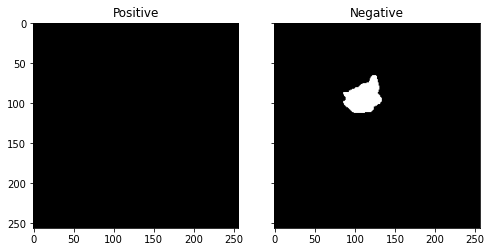

In [11]:
fig = plt.figure(figsize = (8, 8))
grid = ImageGrid(fig, 111, nrows_ncols = (1, 2), axes_pad = 0.5)

grid[0].imshow(cv2.imread(masks.iloc[1]['path']))
grid[0].set_title('Positive')

grid[1].imshow(cv2.imread(masks.iloc[2]['path']))
grid[1].set_title('Negative');

The negative masks have all numbers equal to 0. Positive masks have area with numbers > 0

In [12]:
def set_diagnosis(path):
    if np.max(cv2.imread(path)) > 0:
        return 1
    return 0

data = pd.DataFrame({
    'patient': images['folder'].values,
    'image_path': images['path'].values,
    'mask': masks['path'].values
})
data['diagnosis'] = data['mask'].apply(lambda mask: set_diagnosis(mask))
data.head()

,patient,image_path,mask,diagnosis
0,TCGA_CS_4941_19960909,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,0
1,TCGA_CS_4941_19960909,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,0
2,TCGA_CS_4941_19960909,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,1
3,TCGA_CS_4941_19960909,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,1
4,TCGA_CS_4941_19960909,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,1


# Analysis

0.3494527869686943


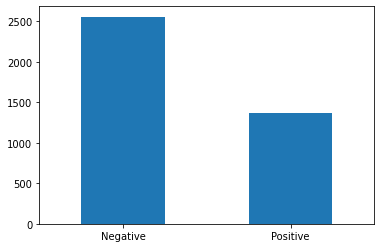

In [13]:
ax = data.diagnosis.value_counts().plot.bar();
ax.set_xticklabels(['Negative', 'Positive'], rotation = 0);
print(data.diagnosis.value_counts()[1] / data.diagnosis.value_counts().sum())

In [14]:
positive_samples = data[data['diagnosis'] == 1].sample(5)['image_path'].sort_values().values
negative_samples = data[data['diagnosis'] == 0].sample(5)['image_path'].values
positive_masks = data.loc[data['image_path'].isin(positive_samples)]['mask'].sort_values().values

for i, (pos, neg, mask) in enumerate(zip(positive_samples, negative_samples, positive_masks)):
    pos = cv2.resize(cv2.imread(pos), (IMAGE_SIZE, IMAGE_SIZE))
    neg = cv2.resize(cv2.imread(neg), (IMAGE_SIZE, IMAGE_SIZE))
    mask = cv2.resize(cv2.imread(mask), (IMAGE_SIZE, IMAGE_SIZE))

    positive_samples[i] = pos
    negative_samples[i] = neg
    positive_masks[i] = mask

positive_samples = np.vstack(positive_samples)
negative_samples = np.vstack(negative_samples)
positive_masks = np.vstack(positive_masks)

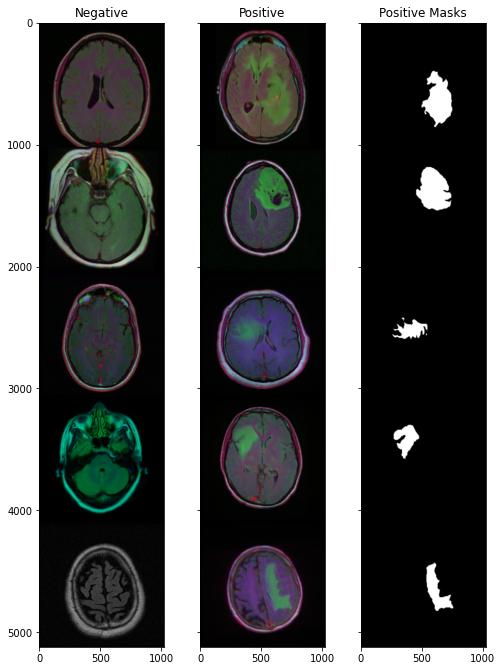

In [15]:
fig = plt.figure(figsize = (8, 14))
grid = ImageGrid(fig, 111, nrows_ncols = (1, 3), axes_pad = 0.5)

grid[0].imshow(negative_samples)
grid[0].set_title('Negative')

grid[1].imshow(positive_samples)
grid[1].set_title('Positive');

grid[2].imshow(positive_masks)
grid[2].set_title('Positive Masks');

# Dataset class and Dataloader class

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

import albumentations as A
from albumentations.pytorch import ToTensor
from torchvision import transforms
from PIL import Image

from sklearn.model_selection import train_test_split

/content/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_12.tif
TCGA_HT_8113_19930809_12.tif
Label = 1
Image Shape: (256, 256, 3)

/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_42.tif
TCGA_DU_6400_19830518_42.tif
Label = 0
Image Shape: (256, 256, 3)

/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_13.tif
TCGA_DU_6407_19860514_13.tif
Label = 0
Image Shape: (256, 256, 3)

/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_28.tif
TCGA_DU_7019_19940908_28.tif
Label = 0
Image Shape: (256, 256, 3)

/content/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_26.tif
TCGA_HT_A616_19991226_26.tif
Label = 0
Image Shape: (256, 256, 3)



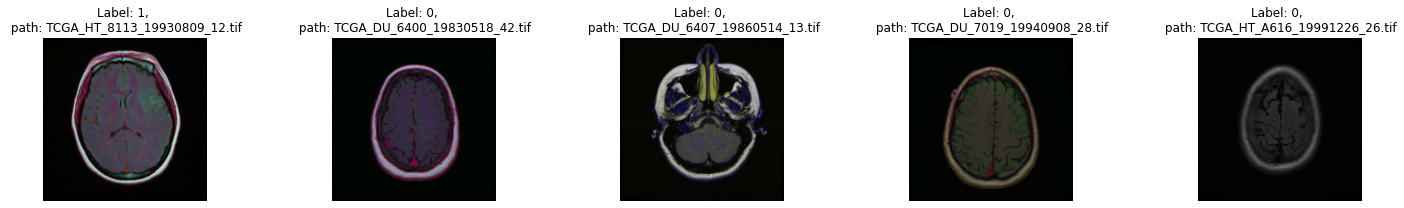

In [17]:
class MRI_dataset(Dataset):
    def __init__(self, data, folder, transform = None):
        self.data = data
        self.folder = folder
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_path = self.data['image_path'].iloc[index]
        mask_path = self.data['mask'].iloc[index]

        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, 0)

        if self.transform:
            augmented = self.transform(image = image, mask = mask)
            image = augmented['image']
            mask = augmented['mask']

        diagnosis = data['diagnosis'][index]
        return image_path, image, mask, diagnosis

def visualize_samples(dataset, indices, count = 5):
    # visualize random samples
    plt.figure(figsize=(count*5,3))
    display_indices = indices[:count]
       
    for i, index in enumerate(display_indices):    
        image_path, image, mask, diagnosis = dataset[index]
        print(image_path)
        path = os.path.split(image_path)[-1]
        print(path)
        print(f"Label = {data[data['image_path'] == image_path]['diagnosis'].to_string().split()[-1]}")
        print(f'Image Shape: {np.array(image).shape}')
        print()
        plt.subplot(1,count,i+1)
        plt.title(f"Label: {diagnosis}, \n path: {path}")
        plt.imshow(image)
        plt.grid(False)
        plt.axis('off')

orig_dataset = MRI_dataset(data, PATH)
indices = np.random.choice(np.arange(len(orig_dataset)), 5, replace = False)

visualize_samples(orig_dataset, indices)

/content/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_12.tif
TCGA_HT_8113_19930809_12.tif
Label = 1
Image Shape: (256, 256, 3)

/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_42.tif
TCGA_DU_6400_19830518_42.tif
Label = 0
Image Shape: (256, 256, 3)

/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_13.tif
TCGA_DU_6407_19860514_13.tif
Label = 0
Image Shape: (256, 256, 3)

/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_28.tif
TCGA_DU_7019_19940908_28.tif
Label = 0
Image Shape: (256, 256, 3)

/content/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_26.tif
TCGA_HT_A616_19991226_26.tif
Label = 0
Image Shape: (256, 256, 3)



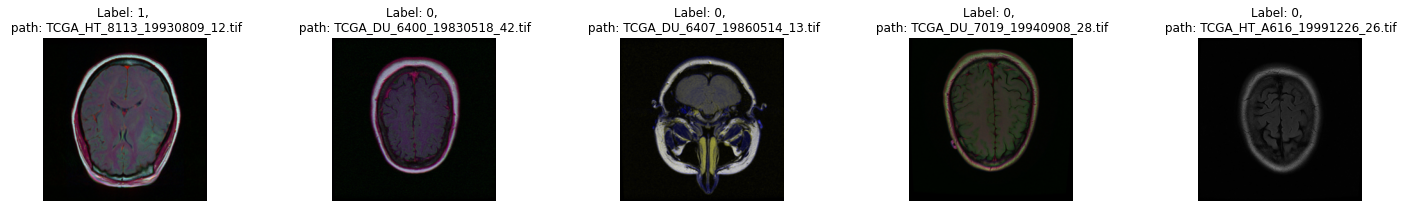

In [18]:
## Let's make sure transforms work!
## Samples with flip - a lot should be flipped!
dataset = MRI_dataset(data, PATH, transform = A.VerticalFlip(1))
visualize_samples(dataset, indices)

In [19]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size = 0.2, random_state = 11)

PATCH_SIZE = 128 #256

transform = A.Compose([
    A.Resize(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),  
    A.Normalize(p=1.0),
    ToTensor(),
])

train_dataset = MRI_dataset(train_data, PATH, transform = transform)

test_dataset = MRI_dataset(test_data, PATH, transform = transform)

In [20]:
len(train_dataset), len(test_dataset)

(3143, 786)

In [21]:
batch_size = 16

data_size = len(train_dataset)
validation_fraction = 0.2

val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(11)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, sampler = train_sampler) 
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, sampler = val_sampler)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size)

In [22]:
## Let's use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# UNet

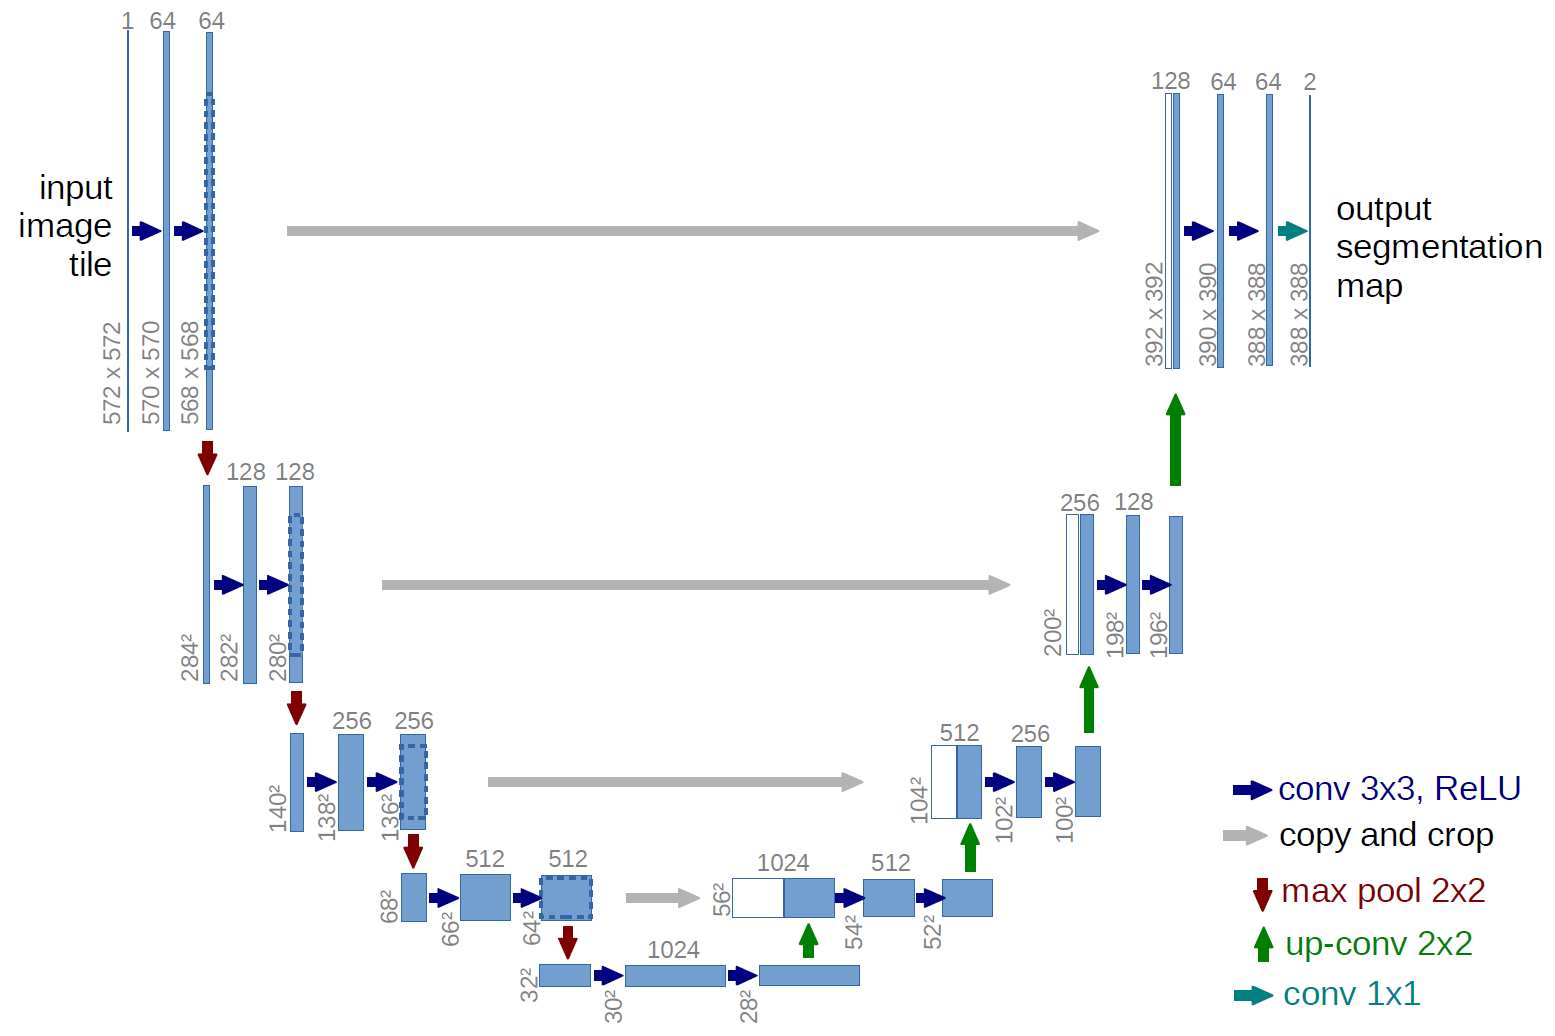

In [90]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding = 1),
        nn.ReLU(inplace = True),
        nn.Conv2d(out_channels, out_channels, 3, padding = 1),
        nn.ReLU(inplace = True))

class UNet(nn.Module):
    def __init__(self, n_classes = 1):
        super().__init__()

        self.conv_down1 = double_conv(3, 64)
        self.conv_down2 = double_conv(64, 128)
        self.conv_down3 = double_conv(128, 256)
        self.conv_down4 = double_conv(256, 512)
        self.conv_down5 = double_conv(512, 1024)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor = 2, mode = 'bilinear', align_corners = True)

        self.conv_up1 = double_conv(1024 + 512, 512)
        self.conv_up2 = double_conv(512 + 256, 256)
        self.conv_up3 = double_conv(256 + 128, 128)
        self.conv_up4 = double_conv(128 + 64, 64)

        self.last_conv = nn.Conv2d(64, n_classes, kernel_size = 1)

    def forward(self, x):
        conv1 = self.conv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.conv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.conv_down3(x)
        x = self.maxpool(conv3)

        conv4 = self.conv_down4(x)
        x = self.maxpool(conv4)

        x = self.conv_down5(x)

        x = self.upsample(x)
        x = torch.cat([x, conv4], dim = 1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        x = torch.cat([x, conv3], dim = 1)
        x = self.conv_up2(x)
        
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim = 1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        x = torch.cat([x, conv1], dim = 1)
        x = self.conv_up4(x)

        x = self.last_conv(x)
        x = torch.sigmoid(x)

        return x

In [91]:
unet = UNet(n_classes = 1).to(device)
output = unet(torch.randn(1,3,256,256).to(device))
print("", output.shape)

 torch.Size([1, 1, 256, 256])


In [92]:
def dice_coef_metric(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return intersection / union

# Metric check
dice_coef_metric(np.array([0., 0.9]), 
                 np.array([0., 1]))

0.9473684210526316

In [93]:
def dice_coef_loss(inputs, target):
    smooth = 1.0
    intersection = 2.0 * ((target * inputs).sum()) + smooth
    union = target.sum() + inputs.sum() + smooth

    return 1 - (intersection / union)


def bce_dice_loss(inputs, target):
    dicescore = dice_coef_loss(inputs, target)
    bcescore = nn.BCELoss()
    bceloss = bcescore(inputs, target)

    return bceloss + dicescore

# loss check
bce_dice_loss(torch.tensor([0.7, 1., 1.]), 
              torch.tensor([1.,1.,1.]))

tensor(0.1637)

In [94]:
def train_model(model_name, model, train_loader, val_loader, train_loss, optimizer, lr_scheduler, num_epochs):  
    
    print(model_name)
    loss_history = []
    train_history = []
    val_history = []

    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        losses = []
        train_iou = []
                
        if lr_scheduler:
            
            warmup_factor = 1.0 / 100
            warmup_iters = min(100, len(train_loader) - 1)
            lr_scheduler = warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)
        
        
        for i_step, (_, data, target, _) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)
                      
            outputs = model(data)
            
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            
            train_dice = dice_coef_metric(out_cut, target.data.cpu().numpy())
            
            loss = train_loss(outputs, target)
            
            losses.append(loss.item())
            train_iou.append(train_dice)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            if lr_scheduler:
                lr_scheduler.step()
 
        #torch.save(model.state_dict(), f'{model_name}_{str(epoch)}_epoch.pt')
        val_mean_iou = compute_iou(model, val_loader)
        
        loss_history.append(np.array(losses).mean())
        train_history.append(np.array(train_iou).mean())
        val_history.append(val_mean_iou)
        
        print("Epoch [%d]" % (epoch))
        print("Mean loss on train:", np.array(losses).mean(), 
              "\nMean DICE on train:", np.array(train_iou).mean(), 
              "\nMean DICE on validation:", val_mean_iou)
        
    return loss_history, train_history, val_history


def compute_iou(model, loader, threshold=0.3):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    #model.eval()
    valloss = 0
    
    with torch.no_grad():

        for i_step, (_, data, target, _) in enumerate(loader):

            data = data.to(device)
            target = target.to(device)
            #prediction = model(x_gpu)
            
            outputs = model(data)
           # print("val_output:", outputs.shape)

            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < threshold)] = 0.0
            out_cut[np.nonzero(out_cut >= threshold)] = 1.0

            picloss = dice_coef_metric(out_cut, target.data.cpu().numpy())
            valloss += picloss

        #print("Threshold:  " + str(threshold) + "  Validation DICE score:", valloss / i_step)

    return valloss / i_step

In [95]:
unet_optimizer = torch.optim.Adamax(unet.parameters(), lr = 1e-4)

def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):
    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha

    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)

In [96]:
%%time
num_ep = 100                                                                                                 
loss, train, val = train_model("UNet", unet, train_loader, val_loader, bce_dice_loss, unet_optimizer, False, num_ep)

UNet
Epoch [0]
Mean loss on train: 1.1052251684514782 
Mean DICE on train: 0.004856360520360889 
Mean DICE on validation: 0.23299042054932037
Epoch [1]
Mean loss on train: 0.7784389127281648 
Mean DICE on train: 0.2734798683392423 
Mean DICE on validation: 0.4247329715684714
Epoch [2]
Mean loss on train: 0.6344835635604738 
Mean DICE on train: 0.4737604700201815 
Mean DICE on validation: 0.49821072568058444
Epoch [3]
Mean loss on train: 0.5417853095863439 
Mean DICE on train: 0.5305033830144394 
Mean DICE on validation: 0.549058504958643
Epoch [4]
Mean loss on train: 0.4838347568919387 
Mean DICE on train: 0.5808992528855598 
Mean DICE on validation: 0.5189513997562217
Epoch [5]
Mean loss on train: 0.4526728948083105 
Mean DICE on train: 0.6070065559626071 
Mean DICE on validation: 0.603415015144455
Epoch [6]
Mean loss on train: 0.4307233930765828 
Mean DICE on train: 0.6324200060432003 
Mean DICE on validation: 0.571333291091354
Epoch [7]
Mean loss on train: 0.4413284002036988 
Mean D

In [ ]:
train_dataset[2490]